In [1]:
import pypsa
import numpy as np
import pandas as pd

In [2]:
%matplotlib inline

# III.2 (a) Network + Buses + Generators

In [3]:
network = pypsa.Network()

## Add North and South Bus

In [4]:
network.add("Bus",
            "North",
            carrier="AC")

In [5]:
network.add("Bus",
            "South",
            carrier="AC")

## Attach constant load

In [6]:
network.add("Load",
            "North Load",
            bus="North",
            p_set=20e3)
network.add("Load",
            "South Load",
            bus="South",
            p_set=30e3)

## Attach renewable generators

In [7]:
network.set_snapshots(np.arange(0, 4*7*24))

In [8]:
Cfw = 0.3
Aw = 0.9
omegaw = 2*np.pi/(7*24)

Cfs = 0.12
As = 1.
omegas = 2*np.pi/24

GNwt = Cfw * (1+Aw*np.sin(omegaw*network.snapshots.to_series()))
GSst = Cfs * (1+As*np.sin(omegas*network.snapshots.to_series()))

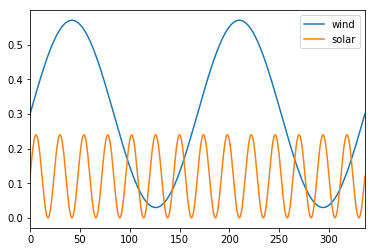

In [9]:
pd.concat([GNwt, GSst], keys=['wind', 'solar'], axis=1).loc[:14*24].plot()

In [10]:
network.add("Generator",
            "Wind",
            bus="North",
            p_nom_extendable=True,
            capital_cost=1.2e6,
            p_max_pu=GNwt)

In [11]:
network.add("Generator",
            "Solar",
            bus="South",
            p_nom_extendable=True,
            capital_cost=0.6e6,
            p_max_pu=GSst)

# III.2 (b) Stores

In [12]:
for bus in ["North", "South"]:
    # H2 storage
    network.add("Bus",
                bus + " H2",
                carrier="H2")
    network.add("Store",
                bus + " H2 St.",
                bus=bus + " H2",
                e_nom_extendable=True,
                capital_cost=10e3)
    network.add("Link",
                bus + "->H2",
                bus0=bus, bus1=bus + " H2",
                p_nom_extendable=True,
                capital_cost=0.3e6,
                efficiency=0.75)
    network.add("Link",
                "H2->" + bus,
                bus0=bus + " H2", bus1=bus,
                p_nom_extendable=True,
                capital_cost=0.45e6,
                efficiency=0.58)
    
    # Battery storage
    network.add("Bus",
                bus + " Battery",
                carrier="Battery")
    network.add("Store",
                bus + " Battery St.",
                bus=bus + " Battery",
                e_nom_extendable=True,
                capital_cost=0.2e6)
    network.add("Link",
                bus + "<->Battery",
                bus0=bus, bus1=bus + " Battery",
                p_nom_extendable=True,
                p_min_pu=-1,
                capital_cost=0.3e6,
                efficiency=0.9)

# III.2 (c) LOPF

In [13]:
network.lopf()

INFO:pypsa.pf:Slack bus for sub-network 0 is North
INFO:pypsa.pf:Slack bus for sub-network 1 is South
INFO:pypsa.pf:Slack bus for sub-network 2 is North H2
INFO:pypsa.pf:Slack bus for sub-network 3 is North Battery
INFO:pypsa.pf:Slack bus for sub-network 4 is South H2
INFO:pypsa.pf:Slack bus for sub-network 5 is South Battery
INFO:pypsa.opf:Performed preliminary steps
INFO:pypsa.opf:Building pyomo model using `angles` formulation
INFO:pypsa.opf:Solving model using glpk
INFO:pypsa.opf:Optimization successful


('ok', 'optimal')

In [20]:
network.objective / 1e9

340.56162935216304

In [21]:
network.generators.p_nom_opt / 1e3

Wind      87.378322
Solar    250.000000
Name: p_nom_opt, dtype: float64

In [23]:
network.stores.e_nom_opt / 1e6

North H2 St.         1.350832e+00
North Battery St.    1.484186e-04
South H2 St.         8.968355e-16
South Battery St.    2.050854e-01
Name: e_nom_opt, dtype: float64

In [24]:
network.links.p_nom_opt / 1e3

North->H2          2.900176e+01
H2->North          2.984945e+01
North<->Battery    6.596843e-02
South->H2         -8.326658e-15
H2->South         -1.558779e-14
South<->Battery    3.000000e+01
Name: p_nom_opt, dtype: float64

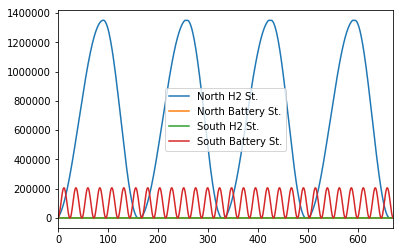

In [25]:
network.stores_t.e.plot()

# III.2 (a-d) with line :)

In [29]:
network.add("Link",
            "North<->South",
            bus0="North", bus1="South",
            p_min_pu=-1,
            p_nom_extendable=True,
            capital_cost=0.2e6)

In [30]:
network.lopf()

INFO:pypsa.pf:Slack bus for sub-network 0 is North
INFO:pypsa.pf:Slack bus for sub-network 1 is South
INFO:pypsa.pf:Slack bus for sub-network 2 is North H2
INFO:pypsa.pf:Slack bus for sub-network 3 is North Battery
INFO:pypsa.pf:Slack bus for sub-network 4 is South H2
INFO:pypsa.pf:Slack bus for sub-network 5 is South Battery
INFO:pypsa.opf:Performed preliminary steps
INFO:pypsa.opf:Building pyomo model using `angles` formulation
INFO:pypsa.opf:Solving model using glpk
INFO:pypsa.opf:Optimization successful


('ok', 'optimal')

In [31]:
network.objective / 1e9

332.221602177086

In [32]:
network.generators.p_nom_opt / 1e3

Wind      92.306059
Solar    241.707119
Name: p_nom_opt, dtype: float64

In [33]:
network.stores.e_nom_opt / 1e6

North H2 St.         1.059891e+00
North Battery St.   -2.217446e-18
South H2 St.         4.335262e-01
South Battery St.    1.178254e-01
Name: e_nom_opt, dtype: float64

In [34]:
network.links.p_nom_opt / 1e3

North->H2          2.335457e+01
H2->North          2.767180e+01
North<->Battery   -1.255376e-14
South->H2          1.405337e+01
H2->South          1.373269e+01
South<->Battery    2.074810e+01
North<->South      9.259880e+00
Name: p_nom_opt, dtype: float64

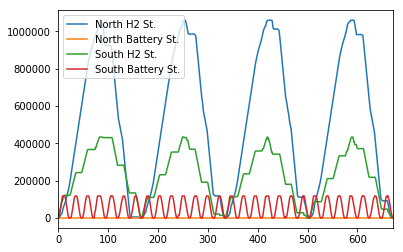

In [35]:
network.stores_t.e.plot()

# III.2 (e) Real availability

In [36]:
network.remove("Generator", "Wind")
network.remove("Generator", "Solar")

In [42]:
availability = pd.read_csv("availability.csv", index_col=0, parse_dates=True)
availability.head()

solar      wind
name                                
2012-01-01 00:00:00    0.0  0.402412
2012-01-01 01:00:00    0.0  0.480648
2012-01-01 02:00:00    0.0  0.542354
2012-01-01 03:00:00    0.0  0.586046
2012-01-01 04:00:00    0.0  0.641201

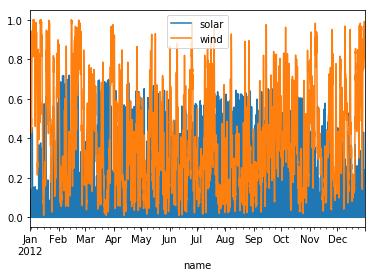

In [43]:
availability.plot()

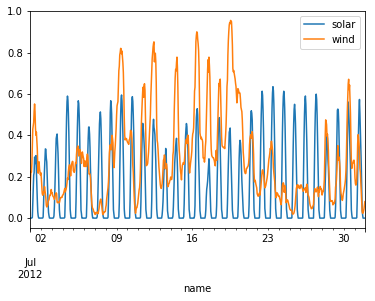

In [47]:
availability.loc["2012-7"].plot()

In [40]:
network.set_snapshots(availability.index)

In [49]:
network.add("Generator",
            "Wind",
            bus="North",
            p_nom_extendable=True,
            capital_cost=1.2e6,
            p_max_pu=availability["wind"])

In [48]:
network.add("Generator",
            "Solar",
            bus="South",
            p_nom_extendable=True,
            capital_cost=0.6e6,
            p_max_pu=availability["solar"])

In [53]:
%%time
network.lopf(solver_name="gurobi")

INFO:pypsa.pf:Slack bus for sub-network 0 is North
INFO:pypsa.pf:Slack bus for sub-network 1 is South
INFO:pypsa.pf:Slack bus for sub-network 2 is North H2
INFO:pypsa.pf:Slack bus for sub-network 3 is North Battery
INFO:pypsa.pf:Slack bus for sub-network 4 is South H2
INFO:pypsa.pf:Slack bus for sub-network 5 is South Battery
INFO:pypsa.opf:Performed preliminary steps
INFO:pypsa.opf:Building pyomo model using `angles` formulation
INFO:pypsa.opf:Solving model using gurobi
INFO:pypsa.opf:Optimization successful


CPU times: user 3min 13s, sys: 2.26 s, total: 3min 15s
Wall time: 10min 19s


('ok', 'optimal')

In [54]:

network.objective / 1e9

397.168566612

In [55]:
network.generators.p_nom_opt / 1e3

Solar    185.138881
Wind     124.722126
Name: p_nom_opt, dtype: float64

In [56]:
network.stores.e_nom_opt / 1e6

North H2 St.         2.123461
North Battery St.    0.032501
South H2 St.         0.827329
South Battery St.    0.220790
Name: e_nom_opt, dtype: float64

In [57]:
network.links.p_nom_opt / 1e3

North->H2          38.016931
H2->North          31.055895
North<->Battery     4.612916
South->H2          14.060751
H2->South          17.600969
South<->Battery    37.832838
North<->South      30.000000
Name: p_nom_opt, dtype: float64

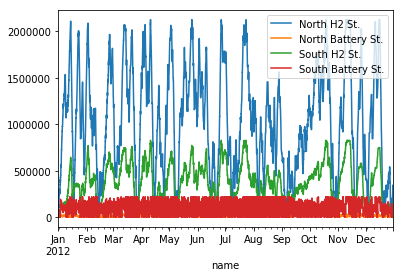

In [58]:
network.stores_t.e.plot()

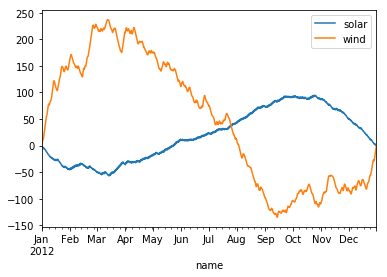

In [63]:
np.cumsum(availability - availability.mean()).plot()